# HumanLoop Data Challenge
## Alberto Raimondi

The task consists of performing data debugging on a model and a related dataset so that different active learning techniques can be used to increase the performance of the model with as little user input as possible. Due to this objective, we will have to focus on a set of possible ways to rank the samples from less to most important so that the user can efficiently focus his efforts during labeling.

A preprocessing step on the data was performed using different techniques, data enrichment was done by querying the HumanLoop API for all the data points to get the predictions of the model. This is time-consuming so the final dataset was serialized and saved using the pickle module. The preprocessing steps can be explored in the `preprocessing.py` script.

In [1]:
# use this to download the spacy model if not installed
# !python -m spacy download en_core_web_trf

In [2]:
import pandas as pd
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_trf")
%matplotlib inline

In [3]:
df = pd.read_pickle("./dataframe.pkl")

We do a small amount of data exploration, due to not having access to the gradients of the model and its parameters there is no way to implement thorough analysis techniques like saliency maps and gradient visualizations on the inputs. We will have to limit ourselves to the entropy of the softmax distribution and the confidence of the model.
We will split the task into two parts:
1. ranking the unlabeled data points
2. testing why labeled samples are hard to classify

In [4]:
#check the usage
df["usage"].unique()

array([None, 'training', 'testing', 'validation'], dtype=object)

In [5]:
df.groupby(["complete"]).count()

,id,usage,score,text,intent,intent_prediction,confidence
complete,,,,,,,
False,193,0,193,193,193,190,190
True,2134,2134,2134,2134,2134,2099,2099


In [6]:
df.groupby(["intent"]).count()

,id,complete,usage,score,text,intent_prediction,confidence
intent,,,,,,,
,193,193,0,193,193,190,190
bill_question,186,186,186,186,186,182,182
calculator,48,48,48,48,48,42,42
card_issue,388,388,388,388,388,380,380
chat_settings,552,552,552,552,552,548,548
credit_question,184,184,184,184,184,181,181
finances,71,71,71,71,71,68,68
insurance_question,88,88,88,88,88,88,88
international,139,139,139,139,139,138,138


.We have only 193 unlabeled data points, so a good initial way to rank them is by the entropy of the model 

In [7]:
df[df["complete"]==False].sort_values("score",ascending=False)

,id,complete,usage,score,text,intent,intent_prediction,confidence
131,602683,False,None,1.554341,routing number for american river,,finances,0.987689
124,602550,False,None,0.949748,how many times have i taken off from work this...,,None,NaN
94,602218,False,None,0.850144,i wanna change my pin number for my credit acount,,None,NaN
186,603393,False,None,0.709459,i cannot remember what my pin is for my bank o...,,chat_settings,0.706303
19,601332,False,None,0.619311,"could you tell me what 30% off 235 is, please",,calculator,0.583609
...,...,...,...,...,...,...,...,...
132,602684,False,None,0.000618,switch to british male accent,,chat_settings,0.995944
5,601226,False,None,0.000596,i think the charge for uber on my account is f...,,card_issue,0.997360
61,601856,False,None,0.000532,someone misused my card and put fraudulent tra...,,card_issue,0.997723
93,602263,False,None,0.000491,my card is to be reported stolen,,card_issue,0.997981


We can also notice that the model often does not give back a prediction, this issue may be related to the confidence of the prediction being under a threshold and stopped from getting served by the API.
For this reason, prioritizing the labeling and examination of items that are not getting an output may be wise.
This may be a problem of the API request step having a bug but after manual investigation, it does not seem to be the case.

In [8]:
df[df["intent_prediction"].isna()].sort_values("score",ascending=False)

,id,complete,usage,score,text,intent,intent_prediction,confidence
646,601409,True,training,1.520790,undo,card_issue,None,NaN
1635,601940,True,testing,1.451263,what's the due date for my american express pa...,bill_question,None,NaN
292,602035,True,training,1.289565,what is 10 to the 12th power,calculator,None,NaN
465,602646,True,training,1.267579,what is the square root of 10294,calculator,None,NaN
528,601257,True,training,1.263117,when is visa due,bill_question,None,NaN
1644,602149,True,testing,1.214983,time zone in miami is what like,international,None,NaN
2206,602944,True,testing,1.152281,what is my fica score,credit_question,None,NaN
2263,601162,True,training,1.150801,how many points did i get on my visa card,credit_question,None,NaN
1842,603269,True,training,1.149448,do a car payment from my savings account,finances,None,NaN
670,602117,True,training,1.134336,mute,chat_settings,None,NaN


Let's check the labeled samples that the model has misclassified, there are only 86 of them.

In [9]:
df["misclassified"] = df["intent"] != df["intent_prediction"]
df_gt = df[df["intent"] != ""]
df_gt = df_gt[df_gt["intent_prediction"].isna()==False]

df_gt.groupby("misclassified").count()


,id,complete,usage,score,text,intent,intent_prediction,confidence
misclassified,,,,,,,,
False,2013,2013,2013,2013,2013,2013,2013,2013
True,86,86,86,86,86,86,86,86


In [10]:
df_gt[df_gt['misclassified']==True]

,id,complete,usage,score,text,intent,intent_prediction,confidence,misclassified
223,602784,True,training,0.707323,what is the turn around for a new card,card_issue,new_application,0.719321,True
224,603364,True,testing,0.747109,how many days did i skip work,work_inquiry,new_application,0.714219,True
226,602996,True,training,0.817582,can you tell me today's rate for cad to usd,international,rates_related,0.598865,True
252,601451,True,testing,0.006338,what day is my car insurance due,bill_question,insurance_question,0.988314,True
255,602979,True,testing,0.026765,what is my credit limit at,finances,credit_question,0.968921,True
...,...,...,...,...,...,...,...,...,...
2224,602761,True,testing,0.028711,i need to know my spending limit on my visa,finances,credit_question,0.971642,True
2244,602708,True,testing,1.049908,i have how many tier credits on my caesar's card,rewards_related,credit_question,0.542017,True
2250,601853,True,testing,0.558031,when can i receive rewards on my visa card,rewards_related,card_issue,0.579144,True
2282,602701,True,training,0.943116,how much am i allowed to spend on my discover ...,finances,credit_question,0.715600,True


There are high confidence items that are misclassified, the entropy seems to be better at representing when the model is not sure.

In [11]:
df_gt[df_gt["misclassified"]]

,id,complete,usage,score,text,intent,intent_prediction,confidence,misclassified
223,602784,True,training,0.707323,what is the turn around for a new card,card_issue,new_application,0.719321,True
224,603364,True,testing,0.747109,how many days did i skip work,work_inquiry,new_application,0.714219,True
226,602996,True,training,0.817582,can you tell me today's rate for cad to usd,international,rates_related,0.598865,True
252,601451,True,testing,0.006338,what day is my car insurance due,bill_question,insurance_question,0.988314,True
255,602979,True,testing,0.026765,what is my credit limit at,finances,credit_question,0.968921,True
...,...,...,...,...,...,...,...,...,...
2224,602761,True,testing,0.028711,i need to know my spending limit on my visa,finances,credit_question,0.971642,True
2244,602708,True,testing,1.049908,i have how many tier credits on my caesar's card,rewards_related,credit_question,0.542017,True
2250,601853,True,testing,0.558031,when can i receive rewards on my visa card,rewards_related,card_issue,0.579144,True
2282,602701,True,training,0.943116,how much am i allowed to spend on my discover ...,finances,credit_question,0.715600,True


Let's check if the entropy of the misclassified items is different from the entropy of the correct ones.
We do the same from the confidence and we notice that the entropy is a much more representative measure of the goodness of a prediction.
This may be to the way the confidence is computed, as it is more representative of the variance of the distribution rather than an estimate of the actual confidence of the model.

Due to this reason, we will prefer to consider entropy as a good measure of uncertainty instead of the confidence.

In [12]:
print(df_gt[df_gt["misclassified"]]["score"].mean())
print(df_gt[df_gt["misclassified"]==False]["score"].mean())

0.3849888912044724
0.04920660238030606


In [13]:
print(df_gt[df_gt["misclassified"]]["confidence"].mean())
print(df_gt[df_gt["misclassified"]==False]["confidence"].mean())

0.7915311192357263
0.958349577183162


We plot the distribution of the entropy and we see that is mostly composed of low values.

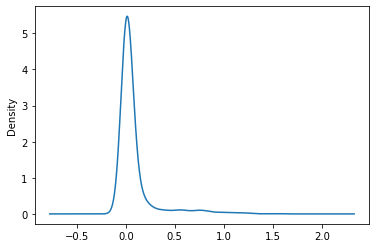

In [14]:
df["score"].plot.kde(bw_method=0.3)

By splitting it by misclassified examples we see that the distribution of the misclassified ones has higher entropy and variance.

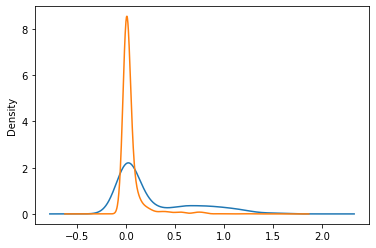

In [15]:
df_misclassified = df[df["misclassified"]==True]
df_misclassified["score"].plot.kde(bw_method=0.3)
df_temp = df[df["misclassified"]==False]
df_temp["score"].plot.kde(bw_method=0.3)

By checking the intent with the highest misclassification rate we can check if we need more samples from that category.

Finances, Calculator and new application intents are the hardest to predict.

In [16]:
misclassified_count= pd.DataFrame() 
misclassified_count["n_misclassified"] = df_misclassified.groupby(["intent"]).count()["id"]
misclassified_count["n_tot"] = df.groupby(["intent"]).count()["id"]
misclassified_count["accuracy"] =misclassified_count["n_misclassified"]/misclassified_count["n_tot"]
misclassified_count

,n_misclassified,n_tot,accuracy
intent,,,
,193,193,1.000000
bill_question,7,186,0.037634
calculator,10,48,0.208333
card_issue,25,388,0.064433
chat_settings,15,552,0.027174
credit_question,3,184,0.016304
finances,25,71,0.352113
international,4,139,0.028777
new_application,12,124,0.096774


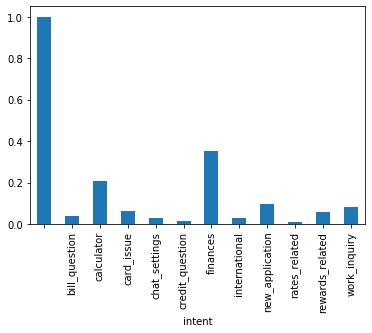

In [17]:
misclassified_count["accuracy"].plot.bar("id","intent")

We now check how the intent influences the confidence of the model by plotting its variance and standard deviation for all the intents.

We can see that the calculator intent seems to be all over the place with a high standard deviation.
This may be due to the numbers being treated in a specific way by the model. 

Both the new_application and the finances question intent have a high average and variance, this could be intuitively motivated by the broad meaning of these two categories.

A possible interesting way to improve the data would be to split these intents into more specific categories, or in alternative increasing their number of samples.

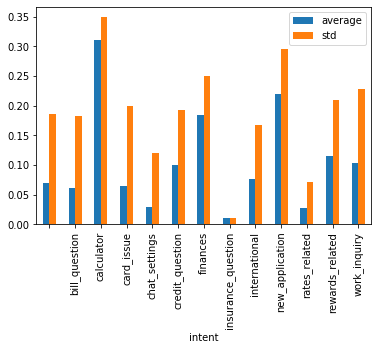

In [18]:
df_intent = pd.DataFrame()
df_intent["intent"] = df.groupby("intent").groups.keys()
df_intent["num"] = df.groupby("intent", as_index=False).count()["complete"]
df_intent["sum"] = df.groupby("intent")["score"].sum().values
df_intent["average"] = df.groupby("intent")["score"].mean().values
df_intent["std"] = df.groupby("intent")["score"].std().values

df_intent.sort_values("average", ascending=False)

df_intent.plot.bar("intent", ["average", "std"])

We check if the model is converged, we don't have access to the full probability distribution of the output so we cannot compute the cross-entropy loss. However, the output entropy could be a good approximation of it.
We see that the entropy on the training and validation dataset is lower than the testing one. This suggests that the model is not fully converged or lacks the capacity to generalize to the test set. More training or a bigger model may help the performance.
Also due to the phenomenon of the double descent, an increase in the capacity of the model could lead to much higher generalization performance.

Another thing this plot suggests is that the validation set may have been used too much and was manually overfitted. Further investigations on the model are warranted.

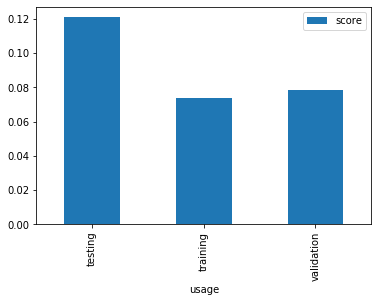

In [19]:
df.groupby("usage", as_index=False).mean().plot.bar("usage", "score")

We use an external mode to do a small part of speech analysis on the text given to the model.
We avoid weighting the samples by their entropy and we just select a threshold value to split the data.
We can see that high entropy samples have more numbers, indicating again that they should be considered in a special way.

Low entropy samples have more verbs and pronouns, meaning that they may be useful to improve the model performance.

In [20]:
def get_pos_counts(string):
    doc = nlp(string)
    pos_list = [token.pos_ for token in doc]
    return dict(Counter(pos_list))


In [21]:
df['text_len']= df['text'].apply(lambda x:len(x.split()))

In [22]:
df['pos_count']= df['text'].apply(get_pos_counts)
df_high_entropy = df[df["score"]>0.05]# this threshold can be an hyperparameter
df_low_entropy = df[df["score"]<=0.05]

pos_list_high = df_high_entropy["pos_count"].tolist()
pos_list_low = df_low_entropy["pos_count"].tolist()

In [23]:
counter = Counter()
for d in pos_list_high: 
    counter.update(d)
      
count_high_entropy_pos = dict(counter)

counter = Counter()
for d in pos_list_low: 
    counter.update(d)
      
count_low_entropy_pos = dict(counter)

In [24]:
low_entropy_pos_average = {k:v/len(df_low_entropy) for k,v in count_low_entropy_pos.items()}
high_entropy_pos_average = {k:v/len(df_high_entropy) for k,v in count_high_entropy_pos.items()}

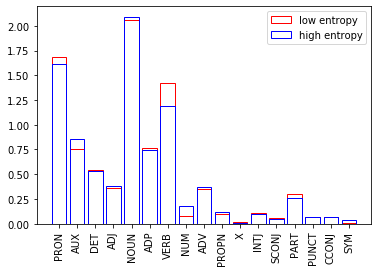

In [30]:
import matplotlib.pyplot as plt
plt.bar(*zip(*low_entropy_pos_average.items()),label= "low entropy",edgecolor='red', color='None')
plt.bar(*zip(*high_entropy_pos_average.items()),label="high entropy",edgecolor='blue', color='None')


plt.xticks( rotation='vertical')
plt.legend()
plt.show()

We check some statistics about the distribution of the length of the input sentence.
It does not seem to affect the misclassification rate much.

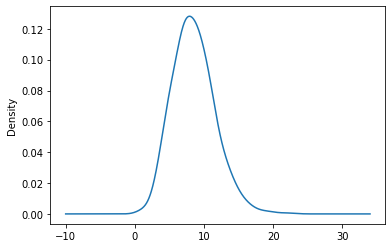

In [26]:
df["text_len"].plot.kde(bw_method=0.3)

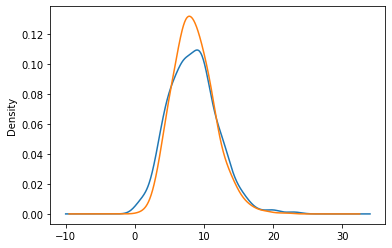

In [27]:
df_temp = df[df["misclassified"]==True]
df_temp["text_len"].plot.kde(bw_method=0.3)
df_temp = df[df["misclassified"]==False]
df_temp["text_len"].plot.kde(bw_method=0.3)

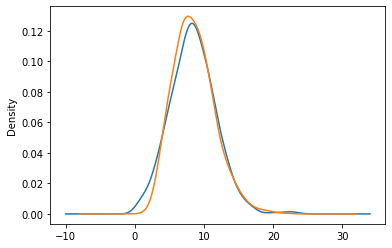

In [28]:
df_high_entropy["text_len"].plot.kde(bw_method=0.3)
df_low_entropy["text_len"].plot.kde(bw_method=0.3)

## Conclusion

In this task, we applied various techniques to explore the dataset and its interaction with the model to find ways to improve the data. We first ranked the unlabeled examples according to the entropy, this was assumed to be a good measure of the difficulty of the data point after some brief descriptive statistics computed on the data. Due to the very low number of unlabeled data points more analysis on them maybe not be representative of their actual impact on the model. For the part of manual data augmentation, we explored various criteria by which new data could be added. To do this we focused on exploring which variables influence more the accuracy and confidence of the model in a prediction.
Various other possible techniques apply to this analysis, some including precomputed word embeddings or active inference using transformers models. This was not implemented in this work for two reasons: The aggregation and analysis of word embeddings, especially when using a weighting coefficient (like the entropy in our case) often proves to be sub-optimal and hard to implement reliably. The linear nature of precomputed embeddings often leads to any aggregate measure being hardly informative about the actual data.
Additionally due to the low volume of the data applying these high dimensionality techniques may be counterproductive.
The final recommendations to improve the dataset are the following:
1. Change how the numbers are represented in the model, the mere presence of a number instead of its value may be much more indicative of the intent of the input.
2. Split the intents "new_application" and "finances" into more specific categories, they are very broad and tend to be the hardest to correctly predict. In alternative getting more data points for these categories could be beneficial
3. If new samples will be manually crafted prefer ones with fewer verbs and pronouns, the model has some difficulties dealing with samples without these parts of speech, and giving it more hard samples should improve its performance
4. On the model side, an increase in model size or in its capacity and training time may prove beneficial. Also, the reduction of the number of regularization techniques applied may be beneficial.
5. The length of the input text seems to not influence the result much so it is of low interest for this task.

The time taken for this analysis was of 4 hours and 15 minutes.